This notebook contains the experiments for the case where model have access to initial web context. Here we try to have the models come up with novel search queries during the debate for disambiguation of their argument.

In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt
from utils.external_retrieval import get_query_answer

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

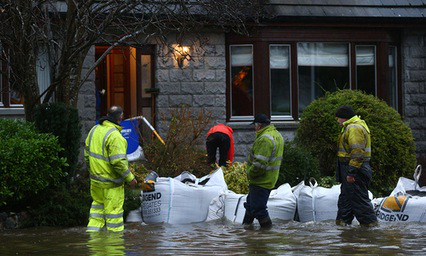

Caption:  Floods swamped the village of Lostwithiel in Cornwall on on November 17 2010 Climate change is increasing the risk of flooding in the UK
Misinformation (Ground Truth): True


In [106]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

data_idx = 17
image, caption, img_path, data_annotation = get_data(data_idx)
display(image)
show_data(data_idx)
image_size = image.size

# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)


In [107]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()

    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [108]:
def initial_prompt_actor(role, text, summary):
    prompt = """{}: This is a summary of text related to the image taken from a news article: {}
Based on this summary and the image provided, you need to determine if the caption given below when used with the image, is being used in a way that's consistent with the content of the news article, or if it's being used to spread false information and mislead people.
CAPTION: {}
Note that the image itself is real and has not been digitally altered. It is taken from a genuine news article.
Carefully examine the image for any known entities, people, watermarks, dates, landmarks, flags, text, logos, and other details which could provide important contextual information.
Your task is to assess whether the image-caption pair, when considered alongside the article summary, presents accurate information or if it's being used in a misleading way. 
Explain your reasoning in detail, considering all aspects of the information provided.
At the end of your analysis, provide a definite YES or NO answer to this question: IS THIS MISINFORMATION?
Remember: In news articles, captions often don't exactly describe the image (but are still related to the image) but are contextually related to the broader story. Focus on whether the image-caption pair, in conjunction with the article summary, presents an accurate representation of the news event or topic.
                    """.format(role, summary, text)
    return prompt

In [109]:
def initial_prompt_skeptic(role, actor_response):
    prompt = """{}: You are a skeptical AI agent tasked with critically evaluating responses and uncovering potential flaws or inconsistencies. Your goal is to formulate a single, targeted question that challenges or clarifies the reasoning presented.
Context: I was given an image from a news article along with a caption. My task was to determine if the caption genuinely belongs to the image and news article, or if it's being used to spread misinformation. Here's their response:
{}
Your task:

Carefully analyze the given response for any potential logical flaws, unsupported assumptions, or areas lacking clarity.
Identify the most crucial aspect of the response that requires further scrutiny or elaboration.
Formulate ONE specific, probing question that directly addresses this aspect.

Your question should:

Be directly related to the details or reasoning provided in the response
Target any ambiguities, inconsistencies, or potential weaknesses in the argument
Aim to reveal any gaps in logic or prompt the agent to provide additional evidence for their claims
Be precise and focused, avoiding broad or general inquiries
DO NOT make up scenarios such as "if .."

Remember, your role is not to determine if the original assessment is correct or incorrect, but to challenge the reasoning process and push for greater clarity and depth of analysis.
                """.format(role, actor_response)
    return prompt

In [110]:
def refine_response_prompt(role, text):
    prompt = """ {}: I am skeptical of what your response. Here is what I have to say: {}. 
                Based on my apprehensions, do you still think you are correct? 
                If required, correct yourself, otherwise refine your response to be more detailed by answering any questions/apprehensions I have.
                At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?
            """.format(role, text)
    return prompt

In [111]:
def end_decision_prompt(role, prev, text):
    prompt = """{}: I took into account your suggestions and refined my response. 
            Earlier my answer to the question: IS THIS MISINFORMATION? was: {}. 
            My new response after taking into account your skepticism is: {}
            If there has been a complete reversal in my response (e.g., from 'Yes, this is misinformation' to 'No, this is not misinformation' or vice versa), be extra cautious and critical in your evaluation and ask me to 'CONTINUE' my analysis.
            If you think my new response is correct and I don't need to refine it further then output 'PERFECT'.
            If you think I should refine my response further and I may be wrong then output: 'CONTINUE'.
            """.format(role, prev, text)
    return prompt

In [112]:
def retrieve_stored_url(key, file_path="../utils/retrieval_urls.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
    urls = data[key]
    return urls

In [113]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 2

In [114]:
search_result = ""
search_done = False
summary_key = str(data_annotation['id'])+"_"+str(data_annotation["image_id"])
context = retrieve_summary(summary_key)
print("CONTEXT: \n\n", context)
image_size = image.size
queries = {0:"", 1:""}
temp = ""
num_passes = 0
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
actor_inp = initial_prompt_actor(roles[0][0], caption, context)
if image is not None:
    # first message
    if models[0]['model'].config.mm_use_im_start_end:
        actor_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + actor_inp
    else:
        actor_inp = DEFAULT_IMAGE_TOKEN + '\n' + actor_inp

conv[0].append_message(conv[0].roles[0], actor_inp)
conv[0].append_message(conv[0].roles[1], None)
actor_outputs = generate_output(0, conv, models, image_tensor, temperature, image_size, max_new_tokens)
conv[0].messages[-1][-1] = actor_outputs
prev_response = True
if "NO" in actor_outputs or "No" in actor_outputs:
    prev_response = False
prev_ques = ""
while num_passes != 3:
    skeptic_inp = initial_prompt_skeptic(roles[1][0], actor_outputs)
    if image is not None:
        # first message
        if models[1]['model'].config.mm_use_im_start_end:
            skeptic_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + skeptic_inp
        else:
            skeptic_inp = DEFAULT_IMAGE_TOKEN + '\n' + skeptic_inp
        image = None
    conv[1].append_message(conv[1].roles[0], skeptic_inp)
    conv[1].append_message(conv[1].roles[1], None)
    skeptic_outputs = generate_output(1, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    if skeptic_outputs == prev_ques:
        break
    else:
        prev_ques = skeptic_outputs
    conv[1].messages[-1][-1] = skeptic_outputs

    actor_inp = refine_response_prompt(roles[0][0], skeptic_outputs)
    if image is not None:
        # first message
        if models[0]['model'].config.mm_use_im_start_end:
            actor_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + actor_inp
        else:
            actor_inp = DEFAULT_IMAGE_TOKEN + '\n' + actor_inp

    conv[0].append_message(conv[0].roles[0], actor_inp)
    conv[0].append_message(conv[0].roles[1], None)
    actor_outputs = generate_output(0, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[0].messages[-1][-1] = actor_outputs
    skeptic_inp = end_decision_prompt(roles[1][0], prev_response, actor_outputs)
    if image is not None:
        # first message
        if models[1]['model'].config.mm_use_im_start_end:
            skeptic_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + skeptic_inp
        else:
            skeptic_inp = DEFAULT_IMAGE_TOKEN + '\n' + skeptic_inp
        image = None
    conv[1].append_message(conv[1].roles[0], skeptic_inp)
    conv[1].append_message(conv[1].roles[1], None)
    skeptic_outputs = generate_output(1, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[1].messages[-1][-1] = skeptic_outputs
    if 'PERFECT' in skeptic_outputs:
        break
    else:
        num_passes += 1
        if "NO" in actor_outputs or "No" in actor_outputs:
            prev_response = False
        else:
            prev_response = True
        continue


CONTEXT: 

 SUMMARY:
            
The recent floods in Scotland have caused significant damage to infrastructure, with two major pieces of infrastructure expected to reopen within the next week. The floods have also caused damage to homes and businesses, with one couple's home flooding for the fourth time. The Scottish government has announced additional funding for affected councils, but the opposition has accused the government of "dragging its feet" over the funding. The floods have also caused disruption to transportation and schools, with over two dozen schools finishing early on Thursday. The Met Office has issued amber and yellow warnings for heavy rain and hill snow, and the temperature is expected to drop over the weekend. Residents in affected areas have been advised to travel only if essential and to deploy sandbags to protect their properties. Social media has been used to share local knowledge and appeals for assistance.
AGENT - 1: 


The image shows a group of people in high-visibility vests standing in floodwater, with a house partially submerged in the background. The caption provided, "Floods swamped the village of Lostwithiel in Cornwall on November 17 2010," suggests that the image is from a flood event that occurred in Lostwithiel, Cornwall, on November 17, 2010.

However, the article summary provided states that the floods are recent and have occurred in Scotland, not Cornwall. The summary also mentions that the Scottish government has announced additional funding for affected councils and that the opposition has accused the government of "dragging its feet" over the funding.

The image does not depict the village of Lostwithiel in Cornwall; it shows a different location in Scotland. The date mentioned in the caption is also inconsistent with the recent nature of the floods described in the article summary.

Given the inconsistencies between the image and the article summary, it is clear that the caption is 

: 